Top phrases for each topic:
Topic 0: sport program, professor online, professor online class, food dining, food dining hall, class difficult, online class difficult, dining hall, wish opportunity, online class
Topic 1: unable food, accessing course material, accessing course, dining hall, access academic, feel like, limited access, mental health, mental health care, health care
Topic 2: mental health, balancing work, balancing work academic, online class, work academic, work academic responsibility, stress aniety, job opportunity, academic responsibility, feel like
Topic 3: access academic advisor, time job, limited access, plan academic, making difficult, academic advisor, end meet, financial aid, concerned lack, feel like
Topic 4: online class, cafeteria offer, university provide, limited access, limited access research, access research, access research database, research database material, database material, research database


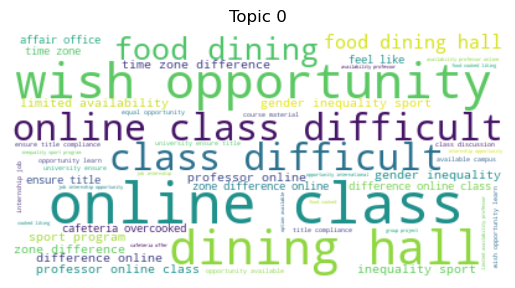

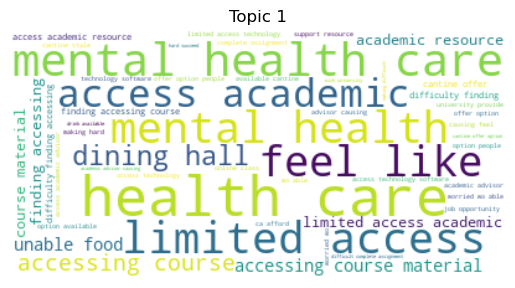

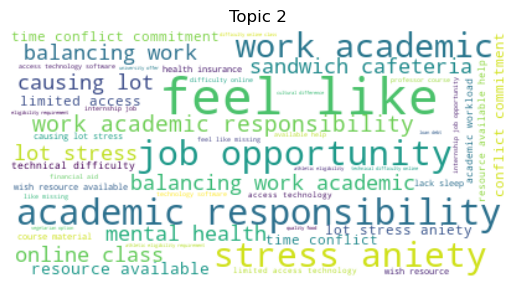

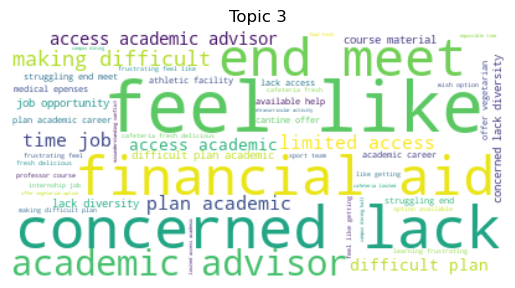

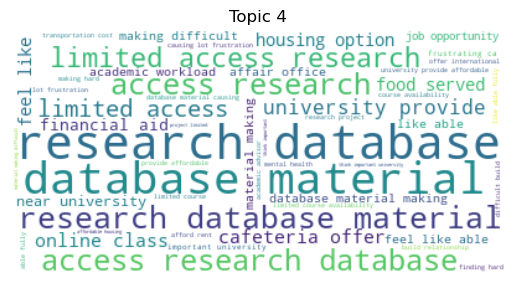

Coherence Score: 0.2035441882538378


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

# Load data
data = pd.read_csv("../data/Datasetprojpowerbi.csv")
flattened_data = pd.json_normalize(data.to_dict(orient="records"))
df_complaints = pd.DataFrame(flattened_data[flattened_data['Reports'] != '']['Reports'])
df_complaints = pd.DataFrame(df_complaints['Reports'].rename('Reports'))

# Preprocessing functions
def clean_whitespace(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_placeholders(text):
    text = re.sub(r'[Xx]+', '', text)
    return text

def lowercase_text(text):
    return text.lower()

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def tokenize_text(text):
    return nltk.word_tokenize(text)

def custom_preprocessor(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t != 'chase']
    return ' '.join(tokens)

def preprocess_text(text):
    text = clean_whitespace(text)
    text = clean_placeholders(text)
    text = lowercase_text(text)
    text = custom_preprocessor(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

# Apply preprocessing
df_complaints['processed_text'] = df_complaints['Reports'].apply(preprocess_text)

# TF-IDF Vectorization
custom_stop_words = list(ENGLISH_STOP_WORDS.union({'need', 'make', 'pay', 'issue', 'problem', 'student'}))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, ngram_range=(2, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_complaints['processed_text'])

# LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display top phrases for each topic
print("Top phrases for each topic:")
for i, topic in enumerate(lda.components_):
    top_features = [tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(top_features)}")

# Assign the most likely topic to each document
df_complaints['topic'] = lda.transform(tfidf_matrix).argmax(axis=1)

# Visualize topics with WordCloud
for i, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(
        {tfidf_vectorizer.get_feature_names_out()[index]: topic[index] for index in topic.argsort()[-50:]}
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()

# Calculate Coherence Score
# Prepare data for Gensim
texts = [text.split() for text in df_complaints['processed_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train Gensim LDA model
gensim_lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Calculate Coherence Score
coherence_model = CoherenceModel(model=gensim_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")